Рассмотрим совместную работу Kandinsky2 с [ControlNet](https://github.com/lllyasviel/ControlNet)

ControlNet — это структура нейронной сети для управления diffusion models  путем добавления дополнительных условий.
Это позволит нам преобразовавть имеющиеся изображения

In [ ]:
!pip install git+https://github.com/huggingface/diffusers.git
!git clone https://github.com/lllyasviel/ControlNet
!pip install einops
!pip install timm
!pip install transformers
!pip install basicsr
!pip install accelerate

  Cloning https://github.com/huggingface/diffusers.git to /tmp/pip-req-build-zsgjnvyc
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers.git /tmp/pip-req-build-zsgjnvyc
  Resolved https://github.com/huggingface/diffusers.git to commit a76f2ad538e73b34d5fe7be08c8eb8ab38c7e90c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.3 MB/s eta 0:00:00
  Created wheel for diffusers: filename=diffusers-0.21.0.dev0-py3-none-any.whl size=1417986 sha256=99b3a5b9cf87310a8f7191c82e1c7e7d45276cc489da17f351ba019a4fe6327f
  Stored in directory: /tmp/pip-ephem-wheel-cache-uo4etjig/wheels/4d/b7/a8/6f9549ceec5daad78675b857ac57d697c387062506520a7b50
Successfully built diffusers
Cloning into 'ControlNet'...
remote: Enumerating objects: 1350, d

In [ ]:
import torch
torch.__version__

'2.0.1+cu118'

In [ ]:
import sys
sys.path.append('/content/ControlNet/')
from annotator.util import resize_image, HWC3
from annotator.midas import MidasDetector
from diffusers import KandinskyV22PriorEmb2EmbPipeline
from diffusers import KandinskyV22ControlnetImg2ImgPipeline
from diffusers import KandinskyV22PriorPipeline
from diffusers import KandinskyV22Pipeline
import torch
import PIL
import torch
from diffusers.utils import load_image
from torchvision import transforms
from transformers import CLIPVisionModelWithProjection
from diffusers.models import UNet2DConditionModel
import numpy as np

In [ ]:
DEVICE = torch.device('cuda')

#Generate

In [ ]:
def make_hint(img, detector):
    input_image = np.array(img)
    img = resize_image(HWC3(input_image), input_image.shape[1])
    H, W, C = img.shape
    detected_map, _ = detector(img)
    detected_map = HWC3(detected_map)
    detected_map = torch.from_numpy(detected_map.copy()).float() / 255.0
    hint = detected_map.permute(2, 0, 1)
    return hint

In [ ]:
image_encoder = CLIPVisionModelWithProjection.from_pretrained('kandinsky-community/kandinsky-2-2-prior',
                                                              subfolder='image_encoder').to(torch.float16).to(DEVICE)


In [ ]:
unet = UNet2DConditionModel.from_pretrained('kandinsky-community/kandinsky-2-2-controlnet-depth', subfolder='unet').to(torch.float16).to(DEVICE)


In [ ]:
detector = MidasDetector()


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


Downloading: "https://huggingface.co/lllyasviel/ControlNet/resolve/main/annotator/ckpts/dpt_hybrid-midas-501f0c75.pt" to /content/ControlNet/annotator/ckpts/dpt_hybrid-midas-501f0c75.pt



100%|██████████| 470M/470M [00:04<00:00, 116MB/s] 
/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(


In [ ]:
prior = KandinskyV22PriorEmb2EmbPipeline.from_pretrained('kandinsky-community/kandinsky-2-2-prior',
                                                         image_encoder=image_encoder,
                                                         torch_dtype=torch.float16)
prior = prior.to(DEVICE)

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
decoder = KandinskyV22ControlnetImg2ImgPipeline.from_pretrained('kandinsky-community/kandinsky-2-2-controlnet-depth',
                                                                unet=unet,
                                                                torch_dtype=torch.float16)
decoder = decoder.to(DEVICE)

movq/diffusion_pytorch_model.safetensors not found


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
img = load_image(
             "https://russian7.ru/wp-content/uploads/2018/03/mmupack_88Y8bQp.jpg"
        ).resize((512, 512))


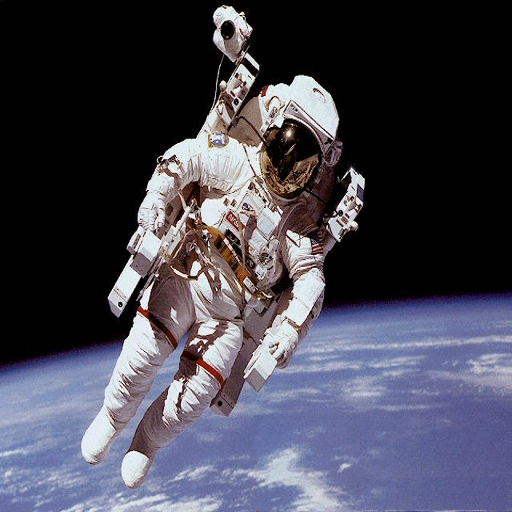

In [ ]:
img

In [ ]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

In [ ]:
images_num=3
negative_prior_prompt ='lowres, text, error, cropped, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, out of frame, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck, username, watermark, signature'
torch.manual_seed(42)
clip_img_emb = prior.interpolate(images_and_prompts=[img], weights=[1], num_images_per_prompt=1, ).image_embeds
img_emb = prior(prompt='A cyberpunk, 4k photo', image=clip_img_emb, strength=0.85, num_inference_steps=25, num_images_per_prompt=1,)
negative_emb = prior(prompt=negative_prior_prompt, image=clip_img_emb, strength=1, num_inference_steps=25, num_images_per_prompt=1)
hint = make_hint(img, detector).unsqueeze(0).half().to(DEVICE).repeat(1, 1, 1, 1)
images = decoder(image=img, strength=0.5, image_embeds=img_emb.image_embeds, negative_image_embeds=negative_emb.image_embeds, hint=hint, num_inference_steps=50, height=512, width=512,num_images_per_prompt=images_num)


  0%|          | 0/21 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck, username, watermark, signature']


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

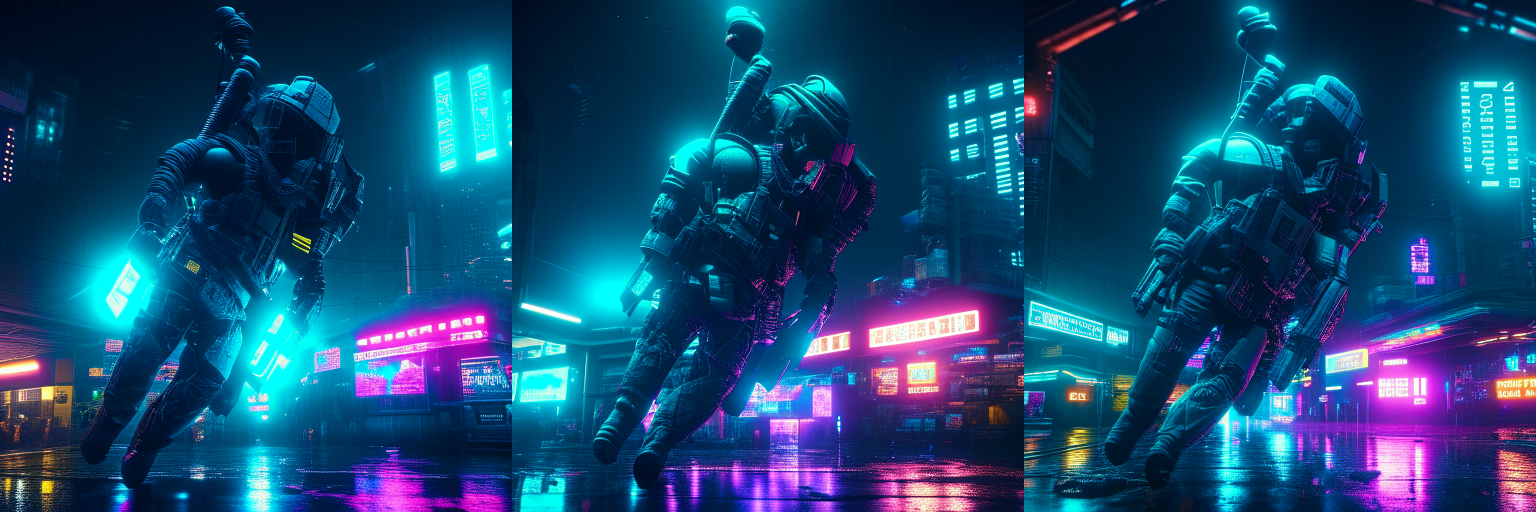

In [ ]:
grid = image_grid(images[0], rows=1, cols=images_num)
grid